## Ячейка с импортом библиотек

In [41]:
import numpy as np
from viewtoolbox import *
from mathtoolbox import *

# Если есть желание сделать графики интерактивными (чтобы был зум и перемещение), 
# снимите комментарий с одной из следующих строчек:
# %matplotlib widget  
# %matplotlib qtagg

## Моделирование фильтров

**Исходные параметры**

Постоянные параметры:

$\bullet$ Частота дискретизации (Гц), $f_{discretization} - $ F_D;

$\bullet$ Интервал дискретизации (сек), $t_{discretization}=1/f_{discretization} - $ T_D;

$\bullet$ Интервал наблюдения (сек), $t_{window} - $ T_WIN;

$\bullet$ Индекс модуляции, $i_{modulation} - $ I_MOD;

$\bullet$ Порядок фильтра Баттерворта $ - $ BUT_ORDER;

$\bullet$ Порядок фильтра Чебышева $ - $ CHEB_ORDER;

$\bullet$ Внеполосное ослабление лепестков для фильтра Чебышева $ - $ S_BAND_ATTENUATION_DB.

In [42]:
# Общие параметры
F_D = 5e9   # частота дискретизации, Гц
T_D = 1/F_D # период дискретизации

# Параметры для моделирования сигнала
T_WIN = 12e-6    # длительность рассматриваемого интервала
I_MOD = 0.5     # индекс модуляции (глубина)

# Параметры для моделирования фильтров
BUT_ORDER = 3   # порядок фильтра Баттерворта
CHEB_ORDER = 3  # порядок фильтра Чебышева
S_BAND_ATTENUATION_DB = 20  # внеполосное ослабление лепестков для фильтра Чебышева

Параметры по варианту:

$\bullet$ Длительность импульса (сек), $ t_{chirp} - $ t_ch;

$\bullet$ Частота несущей (Гц), $f_{carrier} - $ f_car;

$\bullet$ Частота модулирующей гармоники, $ f_{modulation} - $ f_mod;

$\bullet$ Тип фильтра (LP/HP/BP/BS) $ - $ f_type;

$\bullet$ Частота среза (Гц), $f_{cut} - $ f_cut_hz.

In [43]:
# Параметры для моделирования сигнала
t_ch = 2e-6    # длительность импульса (t chirp)
f_car = 140e6   # частота несущей, Гц
f_mod = 5e6     # частота модулирующей синусоиды, Гц

# Параметры для моделирования фильтров
f_type = 'BP'       # тип фильтра (LP/HP/BP/BS)
f_cut_hz = [f_car - 0.5/t_ch, f_car + 0.5/t_ch]   # частота среза, Гц

**Формирование сигнала с заданными параметрами**

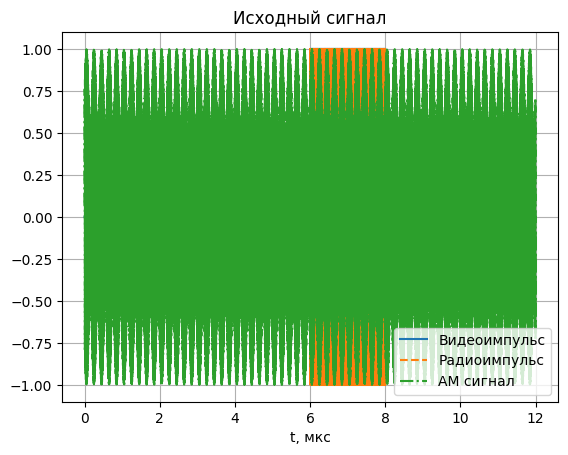

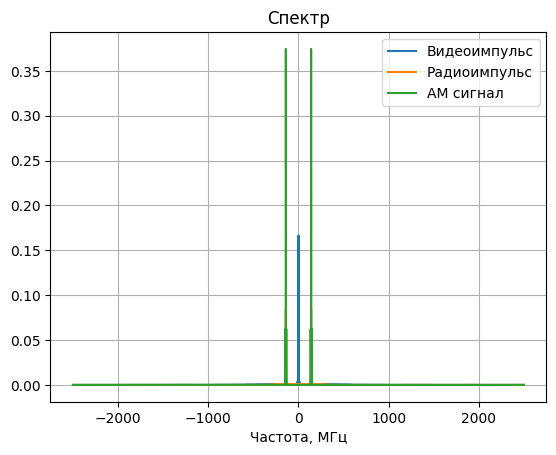

In [44]:
s_v = generate_single_chip('video', T_D, T_WIN, t_ch)   # в/импульс
s_r = generate_single_chip('radio', T_D, T_WIN, t_ch, f_car)    # р/импульс
s_am = generate_single_chip('AM', T_D, T_WIN, f_car, f_mod, I_MOD)  # АМ сигнал

# Циклически "сдвигаем" отсчеты сигнала, чтобы, например, видеоимпульс
# начинался не с первого же отсчета
s_v = np.roll(s_v, math.floor(len(s_v)/2))
s_r = np.roll(s_r, math.floor(len(s_r)/2))
s_am = np.roll(s_am, math.floor(len(s_am)/2))

# "Упаковка" сигналов, на которые хотим посмотреть, в вид, распознаваемый
# функциями отрисовки. Подробности см. в описаниях функций plot_signal()
# и plot_spectrum()
signal_out = [[T_D, s_v, 'Видеоимпульс'],
              [T_D, s_r, 'Радиоимпульс'],
              [T_D, s_am, 'АМ сигнал']]

plot_signal(signal_out) # отобразить сигнал
plot_spectum(signal_out)    # отобразить спектр сигнала


**Сравнение синтезированных фильтров**

*Получение сигнала на выходе синтезированных фильтров:*

In [45]:
signal_in = s_r # выбрать сигнал, который будет отфильтрован
                # Переменная нужна, чтобы во все фильтры гарантированно
                # попал один и тот же сигнал, иначе можно сравнивать
                # разные сигналы и удивлять, что они разные

# Применить к сигналу фильтры. Подробности в описании функций
signal_out_idl = apply_ideal_filter(T_D, f_type, f_cut_hz, signal_in)   # применить к сигналу идеальный фильтр
signal_out_btr = apply_butt_filter(T_D, f_type, f_cut_hz, BUT_ORDER, signal_in) # применить к сигналу ф. Баттерворта
signal_out_chb = apply_cheb2_filter(T_D, f_type, f_cut_hz, CHEB_ORDER, S_BAND_ATTENUATION_DB, signal_in)    # применить к сигналу ф. Чебышева

*Отображение осциллограммы и спектра сигналов на выходе различных фильтров:*

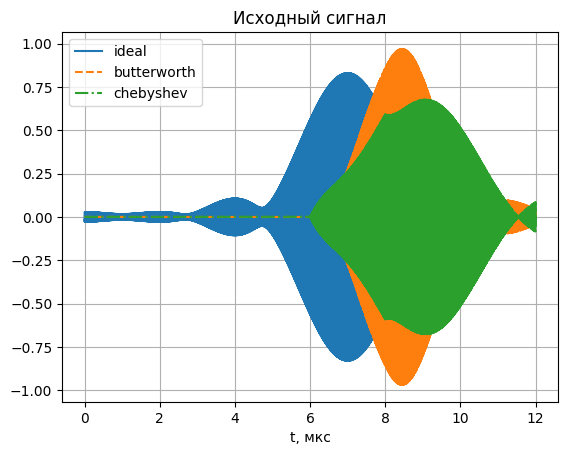

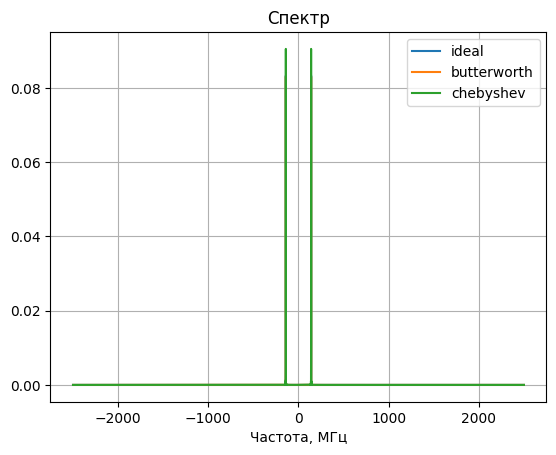

In [46]:
# Отображение данных
signal_out = [[T_D, signal_out_idl, 'ideal'],
              [T_D, signal_out_btr, 'butterworth'], 
              [T_D, signal_out_chb, 'chebyshev']] # конкатенация рез-татов фильтрации

plot_signal(signal_out) # отобразить фильтрованные сигналы
plot_spectum(signal_out) # отобразить спектр 

*Построение импульсной характеристики фильтров:*

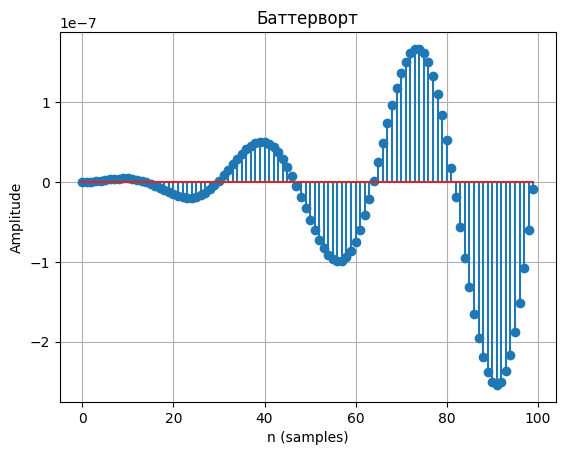

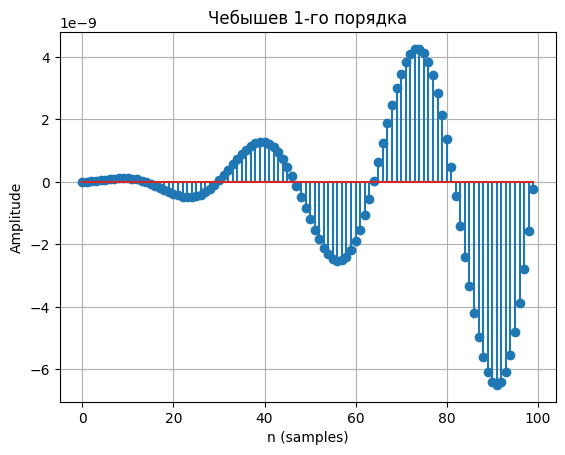

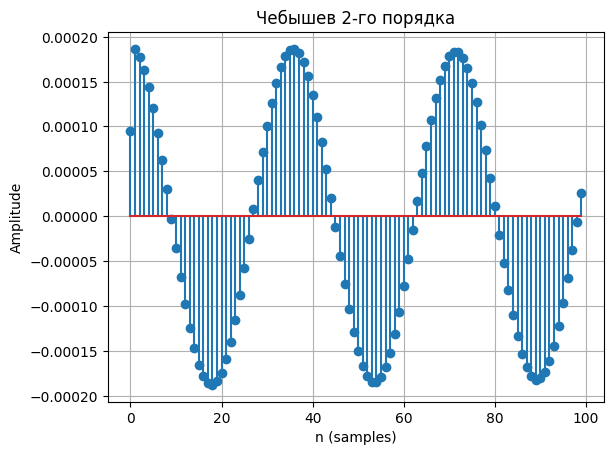

In [47]:
# Получение коэффициентов передаточной функции фильтров для построения импульсной характеристики
b_butt, a_butt = create_butt_filter(T_D, f_type, f_cut_hz, BUT_ORDER)   # формирование фильтра Баттерворта
b_cheb1, a_cheb1 = create_cheb1_filter(T_D, f_type, f_cut_hz, CHEB_ORDER, S_BAND_ATTENUATION_DB)    # формирование фильтра Чебышего 1-го порядка
b_cheb2, a_cheb2 = create_cheb2_filter(T_D, f_type, f_cut_hz, CHEB_ORDER, S_BAND_ATTENUATION_DB)    # формирование фильтра Чебышего 2-го порядка

# Отображение импульсных характеристик фильтров
impz(b_butt, a_butt, 'Баттерворт')
impz(b_cheb1,a_cheb1, 'Чебышев 1-го порядка')
impz(b_cheb2,a_cheb2, 'Чебышев 2-го порядка')

*Построение АЧХ и ФЧХ синтезированных фильтров:*

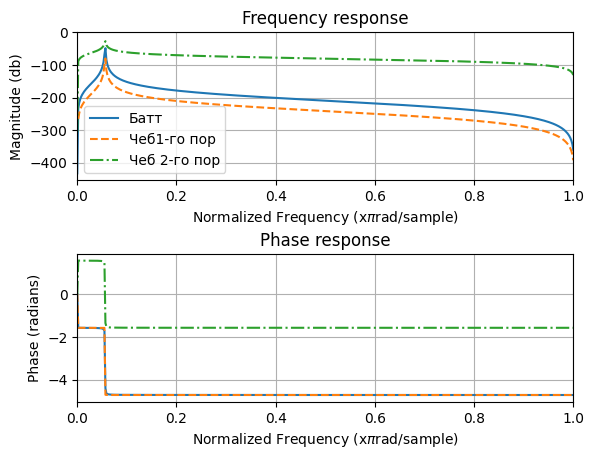

In [48]:
b = [b_butt, b_cheb1, b_cheb2]
a = [a_butt, a_cheb1, a_cheb2]
legend_filters = ['Батт', 'Чеб1-го пор', 'Чеб 2-го пор']

mfreqz3(b, a, legend_filters)